<h1 align="center">Fraud Detection with Variational Autoencoder</h1>

In my [previous naive attempt](https://www.kaggle.com/hone5com/fraud-detection-with-one-class-adversarial-nets) at applying autoencoders to fraud detection, I trained a simple autoencoder with one hidden layer on each of the encoder side and decoder side. The autoencoder was asymmetrical and overcomplete, i.e. the hidden layer dimensions and the latent dimension were asymetrical and larger than the input size. Even so, it seemed to perform alright by piping the latent encoding through a simple linear classifer. An adversarial net was also tried out, but only as a classifier alternative to the linear benchmark. This may be something I would revisit in the future.

In this new attempt, using the same credit card data by ULB machine learning group, I explore applying Variational Autoencoders (VAE) to the same problem. Functionally, Variational Autoencoders also try to reconstruct the input, but with the additional contraint that the latent representation learns the probability distribution parameters of the input rather than an arbitrary encoding of the input, hance the "Variational". What's good about learning the distribution? One, by explicitly modeling the data and noise generation processes, VAE can learn to separate the two, making it more robust. Two, the latent space can become more interpreble if disentanglement constraints are applied. Three, you can generate new samples by sampling latent vectors and pipe them through the decoder. There are more points and I will leave the technical details to the true professionals. You can find the resources that helped me below.

Please feel free to point out any inadequacy. Thank you.

<sup>1</sup> [Building Autoencoders in Keras - Keras Blog](https://blog.keras.io/building-autoencoders-in-keras.html)  
<sup>2</sup> [Variational Autoencoders with Tensorflow Probability Layers - Medium](https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7)  
<sup>3</sup> [Tensorflow Probability VAE Example](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py)  
<sup>4</sup> [Google Colab VAE Interactive Example](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb#scrollTo=9clSiUTiT3G1)  
<sup>5</sup> [An, J., & Cho, S. (2015). Variational autoencoder based anomaly detection using reconstruction probability. Special Lecture on IE, 2, 1-18.](https://pdfs.semanticscholar.org/0611/46b1d7938d7a8dae70e3531a00fceb3c78e8.pdf)


### Contents 

1. Raw Dataset
2. Visualize Preprocessed Transaction Features
3. Train a Variational Autoencoder
4. Visualize Latent Representations 
5. VAE vs SVM
6. Evaluation on Test Set
7. Limitations 

In [1]:
!pip install -q --upgrade tf-nightly==1.14.1-dev20190312 #tf-nightly-gpu==1.14.1-dev20190312
!pip install -q tfp-nightly==0.7.0.dev20190312

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

# import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
np.random.seed(0)
tf.random.set_seed(0)
print(tf.__version__)
print(tfp.__version__)

1.14.1-dev20190312
0.7.0-dev


In [2]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
#     plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud', s=2)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud', s=2)

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()
    

## 1. Raw Dataset

Read the data, split the data into training set and test set. All trials for model design and hyperparameter selection were based solely on the "data" training set. The "data_test" test set was never used until the final evaluation of classifiers before the initial commit of this report.

In [3]:
raw_data = pd.read_csv("../input/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

Following my previous attempt, I transform the Time field to time-of-day to account for intraday seasonality. The Amount field is transformed to log scale, with the intuition that the scale of magnitute of a transaction could be a more relevant feature for fraud than linear amounts.

In [4]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,12.318611,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,0.181618,1.631225,1.176142,-0.241013,1.040992,-0.328446,-0.673208,-0.245852,-0.331582,0.113072,-0.261380,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.570980,0
135660,22.595556,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,0.203961,0.787663,0.882770,0.417271,0.642625,-0.010424,0.161875,-0.835298,0.302139,0.293010,-0.096751,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.026042,0
259186,20.167778,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,-0.158606,-1.137380,0.674799,2.027621,-0.272567,1.802644,-0.812031,0.098509,0.376851,2.958766,0.564341,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,1.938742,0
87387,17.128333,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,1.511193,-0.029435,0.710931,0.088355,-0.913471,-0.376058,-0.992295,0.361036,-1.219535,-0.514430,0.266179,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,2.322388,0
267282,21.195278,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,-0.031401,-1.124247,0.263750,-0.036857,0.617273,-0.146163,-0.774674,-0.240874,-0.438419,0.273518,-0.139341,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,3.882182,0


## 2. Visualize Preprocessed Transaction Features
Sample 1000 non-fraud transactions from the training set and plot with all fraudulent transactions in the training set. The T-SNE plot shows that after Time and Amount preprocessing, fraud transactions (in red) seem to be adequately seperated from non-fraud transactions (in green) in this particular projection.

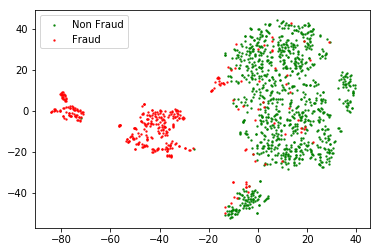

In [5]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

tsne_plot(X, Y, "original.png")

## 3. Train a Variational Autoencoder
We train a VAE with 100k in-sample non-fraud transactions. As this is for exploratory and illustration purpose, the hidden layer design was by trial and error. 

The prior for the latent variables was set to be a random unit multivariate normal vector of the latent dimention. The latent dimension is set to 2 so that it give some intuitive illustrations as you will see soon. 

The output of the encoder, the latent distribution parameters, was deliberated chosen to be multiviarate normal with non-zero covariance because I noticed it had subsequent impact on the separation of normal transactions from fraud transactions, suggesting that the covariance of fraud transactions may have patterns. As a result, there are 5 distribution parameters to be learnt (2 mean values + 3 covariance values from the lower triangle of the 2-buy-2 covariance matrix)

The output of the decoder, the data distribution parameters, follow feature-independent normal distributions. This choice is important. Most of the examples I could find online were applied to binary images such as the MNIST dataset where the output would follow independent bernoulli distributions. Here the data are real-valued and generally follow normal distributions, hence it only makes sense to model the output with normal distributions or alike. Another important implication of having the right distribution is that it will give the corresponding log probability loss during training. It would not make sense to train a real-valued normal distribution using binary cross entropy, for example.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8)                 918       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 20)                334       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                1260      
____________________________________________

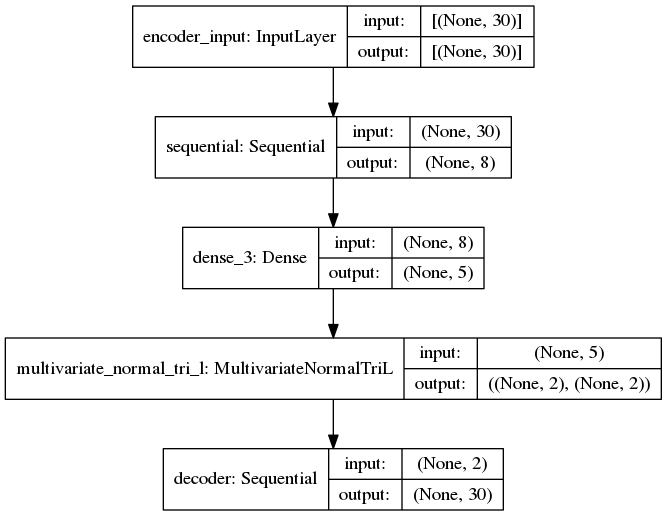

In [6]:
def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 1000

# prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
#                         reinterpreted_batch_ndims=1)

prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    dense_layers(intermediary_dims),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, 
                           activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
], name='encoder')

encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
            loss=negloglik)

vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

In [7]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [8]:
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

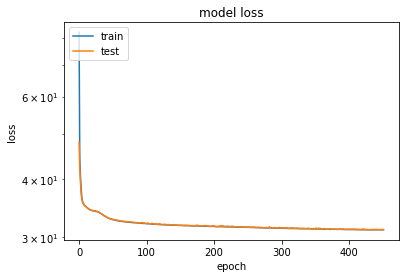

In [9]:
checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[checkpointer, earlystopper])

plot_loss(hist)


The training stops when the validation losses fail to decrease for 20 consecutive epochs.

Define a function that would perform Monte Carlo on inputs to compute the reconstruction probability (given the output data distribution, what would be the probability to generate the original input?). I sample 100 times for each input.

In [10]:
# vae.load_weights('bestmodel.h5', by_name=True)

In [11]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

## 4. Visualize Latent Representations 
T-SNE plots of latent distribution parameters and samples for the previously sampled data. Notice how the clustering are very pronounced across all plots.

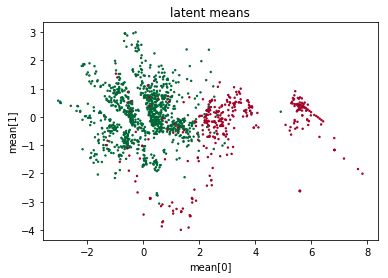

In [12]:
latent_x_mean = encoder(X).mean()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()
# tsne_plot(latent_x_mean, data_sample["Class"].values, "raw.png")

There is a clear separation between the fraud and non-fraud transactions around the origin [0,0] mean vector, a sign that the VAE is learning something meaningful.

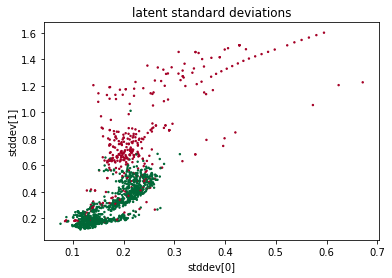

In [13]:
latent_x_std = encoder(X).stddev()
plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

Notice how the fraud transactions's standard deviations in red are much more scattered and tend to have higher values in both axes. This is inline with the intuition that fraud transactions tend to be erratic.

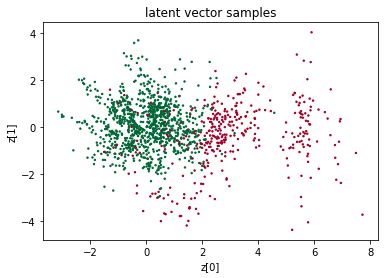

In [14]:
latent_x = encoder(X).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

The sampled latent vector z. The clustering and scattering are consistent with previous observations.

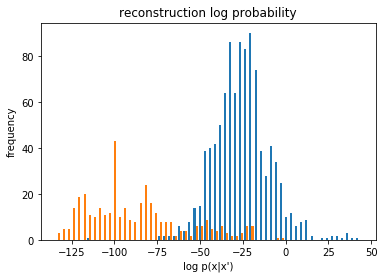

In [15]:
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
ax = plt.hist([x_log_prob[Y==0], x_log_prob[Y==1]], 60)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()

Looking at the log of the reconstruction probability, fraud transactions in orange are clearly separeted from normal transaction in most cases despite some overlaps. Normal transactions have higher reconstruction probability, of course.

Now, let's take the negative reconstruction log probability, and draw a ROC curve across the range to see how it would perform if we were to build a threshold-based fraud detector on it.

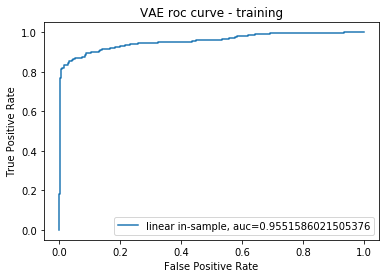

In [16]:
fpr, tpr, thresh = roc_curve(Y, -x_log_prob)
auc = roc_auc_score(Y, -x_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

Above 0.96 in training set, pretty decent!

## 5. VAE vs SVM
Let's compare this with a trivial supervised SVM classifier. I am curious if SVM would outperform VAE, since the preprocessed input seemed to give good separation between frauds and non-frauds. Turns out it did not. VAE for the win!

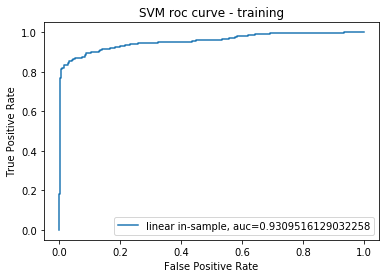

In [17]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X, Y)
auc = roc_auc_score(Y, clf.predict(X))

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('SVM roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

## 6. Evaluation on Test Set
Evaluate VAE and a trivial SVM on the previously reserved test set. VAE outperforms the simple SVM.

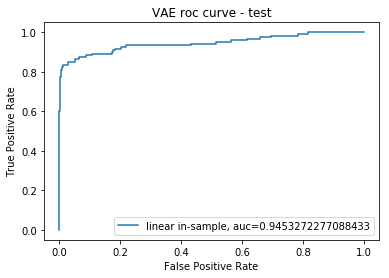

In [18]:
x_test_log_prob = reconstruction_log_prob(data_test.drop(['Class'], axis = 1).values, reconstruct_samples_n)
test_y = data_test["Class"].values

fpr, tpr, thresh = roc_curve(test_y, -x_test_log_prob)
auc = roc_auc_score(test_y, -x_test_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

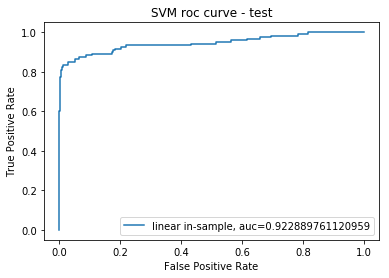

In [19]:
auc = roc_auc_score(test_y, clf.predict(data_test.drop(['Class'], axis = 1).values))

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('SVM roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

## 7. Limitations 
* The VAE hidden layer design has room for improvement.
* Hyperparameter tuning can be added.